In [ ]:
"""
This notebook demonstrates mixing of 1 bit PDM signals

* A reference signal is generated with multiple tones and chirps.
* The reference signal is converted to 1 bit PDM using configurable dither.
* A 1 bit PDM local oscillator is generated to mix the signal down to baseband.
* The signals are mixed using XNOR operations
* The mixed signal is low-pass filtered and decimated to produce the final output.
    * XNOR is used because it produces the correct truth table for a multiplication where inputs are in {0,1} but are treater as if they were in {-1,+1}.
* The signal is converted from the {0, 1} representation to a complex float representation {-1.0, +1.0}
* The output signal is low-pass filtered and decimated to produce the final baseband output.

This demonstrates a technique which could be implemented efficiently in an FPGA.


           ┌────────────┐                PDM LO (re)
  Signal ──┤ +          │                    |
           │  Comparator├─── LVDS PDM ──┬─ XNOR ─ Low-pass ─ Decimate ─ Baseband (re)
  Dither ──┤ -          │               │
           └────────────┘               └─ XNOR ─ Low-pass ─ Decimate ─ Baseband (im)
                                             |
                                          PDM LO (im)
  Notes:
   * The comparator outputs a 1-bit PDM stream (LVDS).
   * Dither drives the negative input (threshold modulation).
   * Two XNOR mixers implement complex PDM LO mixing (re/im).
   * Subsequent low-pass + decimate stages recover the baseband.
   * The PDM LO is also generated using dithered 1-bit conversion of a complex tone.
   * We feed Dither into the negative input of the comparator instead of adding it to the signal like in traditional dithering.
      * This is equivalent to adding dither to the signal, but is simpler in hardware
"""

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.signal import firwin, lfilter

def gen_complex_tone(fs, n_samples, f):
    """
    Generate a complex tone at frequency f.
    fs: sample rate
    n_samples: number of samples
    f: frequency of the tone
    """
    t = np.arange(n_samples) / fs
    return np.exp(2j * np.pi * f * t)

def gen_tone(fs, n_samples, f):
    """
    Generate a real tone at frequency f.
    fs: sample rate
    n_samples: number of samples
    f: frequency of the tone
    """
    t = np.arange(n_samples) / fs
    return np.cos(2 * np.pi * f * t)

def gen_chirp(fs, n_samples, f0, f1):
    """
    Generate a complex linear chirp from f0 to f1.
    fs: sample rate
    n_samples: number of samples
    f0: starting frequency
    f1: ending frequency
    """
    t = np.linspace(0, n_samples / fs, n_samples, endpoint=False)
    tone = scipy.signal.chirp(t, f0, t[-1], f1, method='linear')
    return tone

def analogue_to_pdm_gaussian(signal: np.ndarray, noise_level=0.25) -> np.ndarray:
    """
    Convert an analogue signal to a 1-bit PDM signal using Gaussian noise.
    noise_level: standard deviation of the Gaussian noise added to the signal.
    Returns {0,1} array.
    """
    pdm_signal = np.zeros_like(signal, dtype=np.int8)
    noise = np.random.normal(0, noise_level, len(signal))

    pdm_signal[(signal + noise) > 0] = 1

    return pdm_signal

def analogue_to_pdm_triangular(signal: np.ndarray, amp=0.5) -> np.ndarray:
    """
    Convert an analogue signal to a 1-bit PDM signal using triangular dither.
    Triangular dither: sum of two independent uniform randoms => triangular PDF.
    amp is peak amplitude of the dither relative to your signal amplitude.
    Returns {0,1} array.
    """
    u1 = np.random.uniform(-1.0, 1.0, len(signal))
    u2 = np.random.uniform(-1.0, 1.0, len(signal))
    tri = 0.5 * (u1 + u2) * amp

    pdm_signal = np.zeros_like(signal, dtype=np.int8)
    pdm_signal[(signal + tri) > 0] = 1
    return pdm_signal

def analogue_to_pdm_threshold(signal: np.ndarray) -> np.ndarray:
    """
    Convert an analogue signal to a 1-bit PDM signal using simple thresholding.
    Returns {0,1} array.
    """
    pdm_signal = np.zeros_like(signal, dtype=np.int8)
    pdm_signal[signal > 0] = 1
    pdm_signal[signal <= 0] = 0
    return pdm_signal.astype(np.uint8)

def lowpass_fir(signal, fs, cutoff, numtaps=101):
    """
    Simple low-pass FIR filter using a Hamming window.
    signal: input (can be complex or real)
    fs: sample rate
    cutoff: cutoff frequency in Hz (or normalized if you prefer)
    numtaps: number of filter taps (higher = sharper rolloff)
    """
    taps = firwin(numtaps, cutoff / (fs / 2), window="hamming")
    return lfilter(taps, 1.0, signal)

def gen_onebit_lo(fs, n_samples, f_lo, dither_type='triangular', dither_amp=0.5):
    """
    Generate a 1-bit PDM local oscillator at frequency f_lo.
    fs: sample rate
    n_samples: number of samples
    f_lo: frequency of the local oscillator
    dither_type: type of dither to use ('triangular', 'gaussian', or 'threshold')
    """

    lo = gen_complex_tone(fs, n_samples, f_lo)
    if dither_type == 'triangular':
        lo_i = analogue_to_pdm_triangular(lo.real, dither_amp)
        lo_q = analogue_to_pdm_triangular(lo.imag, dither_amp)
    elif dither_type == 'gaussian':
        lo_i = analogue_to_pdm_gaussian(lo.real, dither_amp)
        lo_q = analogue_to_pdm_gaussian(lo.imag, dither_amp)
    elif dither_type == 'threshold':
        lo_i = analogue_to_pdm_threshold(lo.real, dither_amp)
        lo_q = analogue_to_pdm_threshold(lo.imag, dither_amp)
    else:
        raise ValueError("Invalid dither_type. Choose 'triangular', 'gaussian', or 'threshold'.")

    return lo_i, lo_q

def onebit_mixer(signal, lo_freq, fs, filter_cutoff, decimation, pdm_method='triangular', triangular_dither_amp=0.5):
    """
    Mix a signal down to baseband
       * Convery the signal to 1-bit PDM using the specified method
       * Generate a 1-bit PDM local oscillator at lo_freq
       * Mix the signal using XNOR operations
       * Low-pass filter and decimate the result
    signal: input analogue signal (1D numpy array)
    lo_freq: frequency of the local oscillator
    fs: sample rate of the input signal
    filter_cutoff: cutoff frequency of the low-pass filter
    decimation: decimation factor after low-pass filtering
    pdm_method: method to convert analogue signal to PDM ('triangular' or 'threshold')
    triangular_dither_amp: amplitude of triangular dither if pdm_method is 'triangular'
    Returns: baseband complex signal after mixing, filtering, and decimation
    """
    # Generate local oscillator
    lo_i, lo_q = gen_onebit_lo(fs, len(signal), lo_freq)

    if pdm_method == 'triangular':
        sig_1bit = analogue_to_pdm_triangular(signal, amp=triangular_dither_amp)
    elif pdm_method == 'threshold':
        sig_1bit = analogue_to_pdm_threshold(signal)
    else:
        raise ValueError("Invalid pdm_method. Choose 'triangular' or 'threshold'.")

    mix_i_bits = np.bitwise_not(np.bitwise_xor(sig_1bit, lo_i)) & 1
    mix_q_bits = np.bitwise_not(np.bitwise_xor(sig_1bit, lo_q)) & 1

    # {0,1} -> {-1,+1}
    mix_i_bip = mix_i_bits.astype(np.int8) * 2 - 1
    mix_q_bip = mix_q_bits.astype(np.int8) * 2 - 1
    mix_iq = mix_i_bip.astype(np.float32) + 1j * mix_q_bip.astype(np.float32)

    lp = lowpass_fir(mix_iq, fs, cutoff=filter_cutoff, numtaps=10001)

    # Decimate the filtered signal
    lp_decimated = lp[::decimation]

    return lp_decimated

def gen_signal(fs, n_samples, tones, chirps, noise_floor_db):
    """
    Generate a test signal with multiple tones, chirps, and noise floor.
    tones: list of (frequency, amplitude_db)
    chirps: list of (f0, f1, amplitude_db)
    noise_floor_db: noise floor level in dB
    """
    # Generate the base signal
    sig = np.zeros(n_samples)

    for freq, amp_db in tones:
        amp = 10 ** (amp_db / 20)
        sig += gen_tone(fs, n_samples, freq) * amp

    for f0, f1, amp_db in chirps:
        amp = 10 ** (amp_db / 20)
        sig += gen_chirp(fs, n_samples, f0, f1) * amp

    # Add noise
    noise_floor = 10 ** (noise_floor_db / 20)
    sig += np.random.normal(0, noise_floor, len(sig))

    return sig



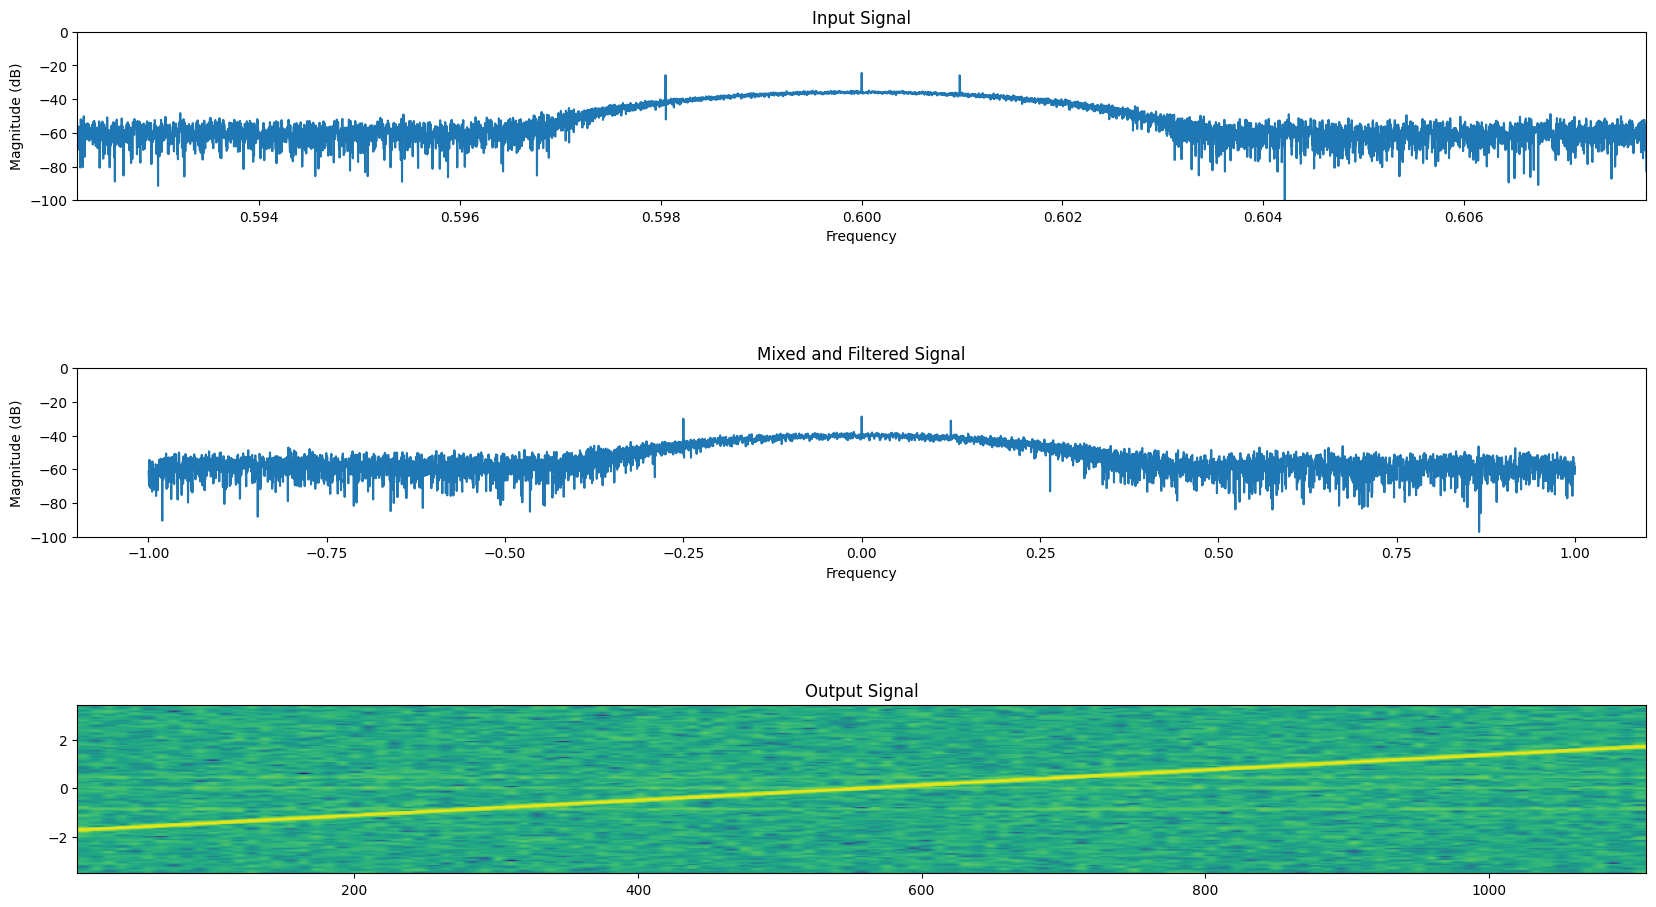

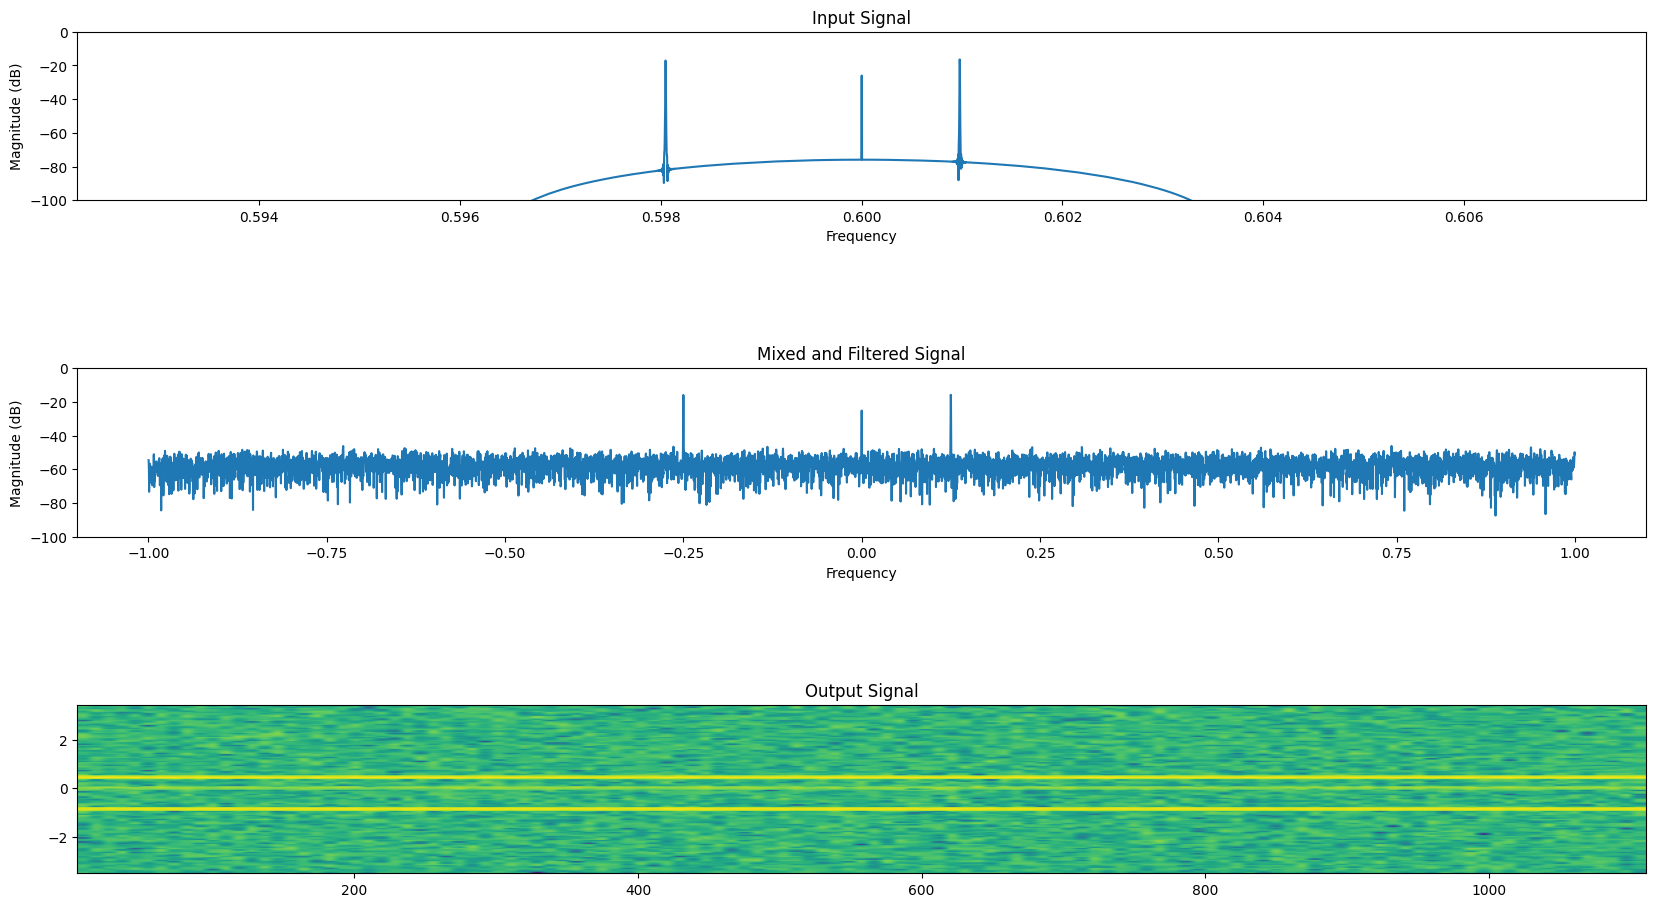

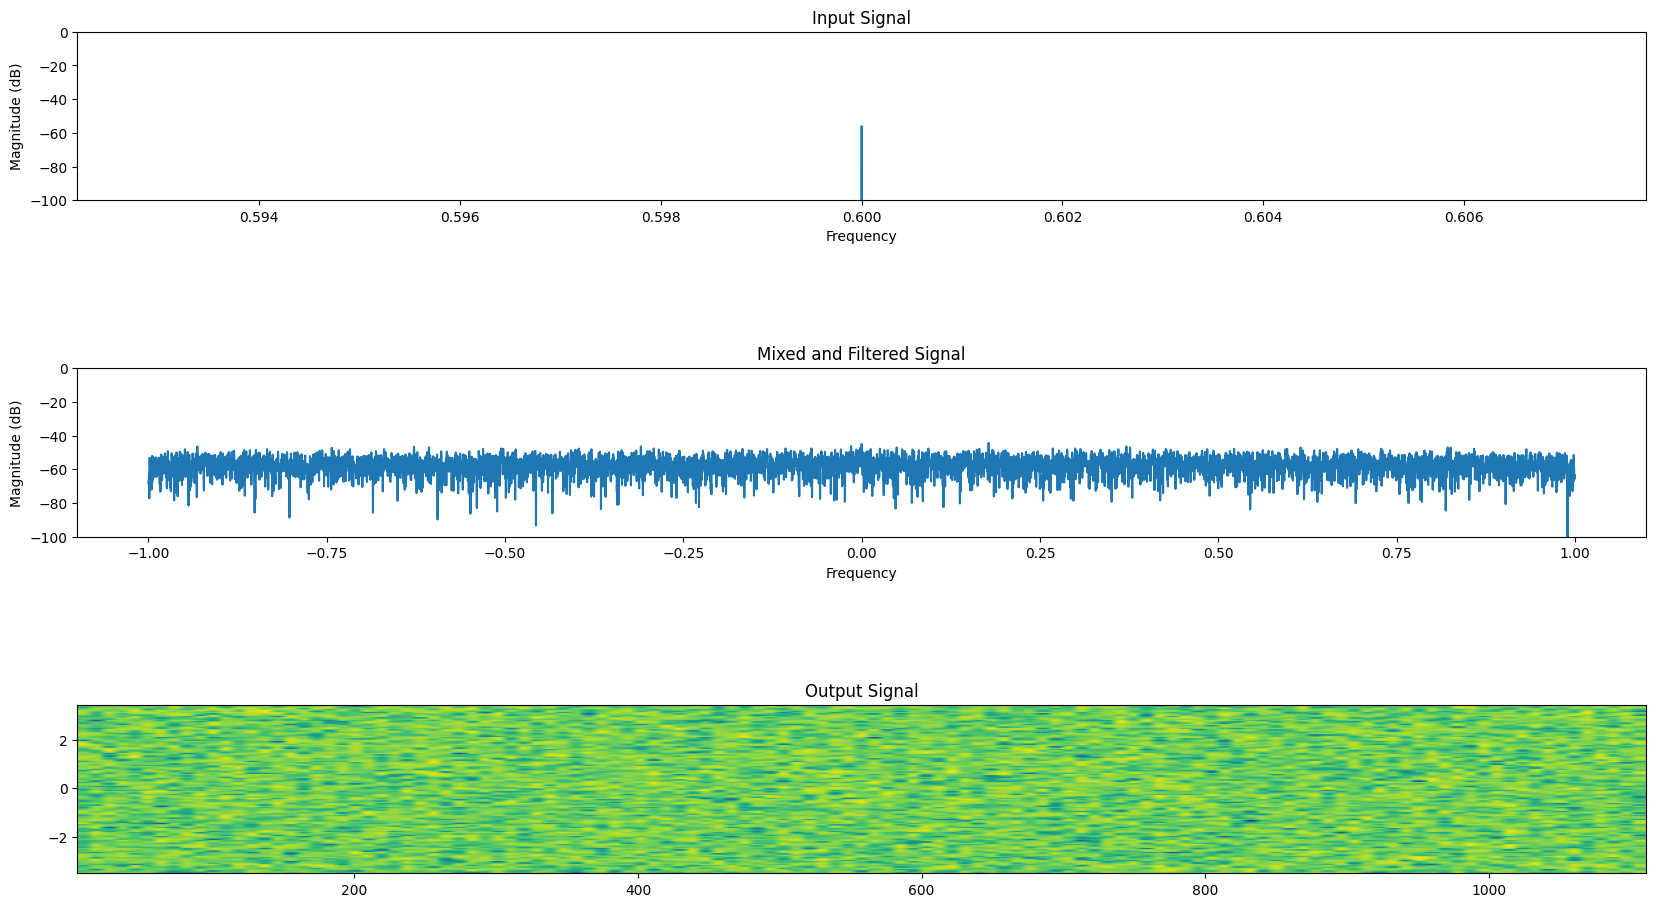

In [3]:
def plot_1bit_mixer_run(signal, result, sample_rate, bw_ratio, f_sig):
    fig, axs = plt.subplots(3)

    axs[0].set_title("Input Signal")
    axs[0].magnitude_spectrum(signal, scale="dB", label="Input Signal")
    axs[0].set_ylim([-100, 0])
    cf = (f_sig / sample_rate) * 2
    axs[0].set_xlim([cf - 2/bw_ratio, cf + 2/bw_ratio])

    axs[1].set_title("Mixed and Filtered Signal")
    axs[1].magnitude_spectrum(result, scale="dB", label="PDM Mixed signal")
    axs[1].set_ylim([-100, 0])

    axs[2].set_title("Output Signal")
    axs[2].specgram(result, NFFT=128, Fs=sample_rate//(bw_ratio//2), noverlap=64, scale="dB")

    plt.tight_layout()
    fig.set_size_inches(18.5, 10)
    plt.show()


N_SAMPLES = 1000000
SAMPLE_FREQUENCY = 1000
BW_RATIO = 256
BW_SIG = SAMPLE_FREQUENCY / BW_RATIO
F_LO = -0.3 * SAMPLE_FREQUENCY
F_SIG = 0.300 * SAMPLE_FREQUENCY

lo = gen_complex_tone(SAMPLE_FREQUENCY, N_SAMPLES, F_LO)

signal_specs = [
    {
        'tones': [(F_SIG - BW_SIG / 4, -20), (F_SIG, -20), (F_SIG + BW_SIG / 8, -20), (F_SIG - BW_SIG / 4 + BW_SIG*2, -20), (F_SIG + BW_SIG*2, -20), (F_SIG + BW_SIG / 8 + BW_SIG*2, 0)],
        'chirps': [(F_SIG - BW_SIG / 2, F_SIG + BW_SIG / 2, 0)],
        'noise_floor_db': -0,
        'decimation': 128,
        'dither_amp': 2
    },
    {
        'tones': [(F_SIG - BW_SIG / 4, -10), (F_SIG, -20), (F_SIG + BW_SIG / 8, -10)],
        'chirps': [(F_SIG - BW_SIG / 2, F_SIG + BW_SIG / 2, -40)],
        'noise_floor_db': -100,
        'decimation': 128,
        'dither_amp': 2
    },
    {
        'tones': [(100, -30), (200, -40), (300, -50)],
        'chirps': [],
        'noise_floor_db': -60,
        'decimation': 128,
        'dither_amp': 2
    }
]

for spec in signal_specs:
    sig = gen_signal(SAMPLE_FREQUENCY, N_SAMPLES,
            tones=spec['tones'],
            chirps=spec['chirps'],
            noise_floor_db=spec['noise_floor_db'])

    lp = onebit_mixer(sig, F_LO, SAMPLE_FREQUENCY, filter_cutoff=BW_SIG, decimation=spec['decimation'], triangular_dither_amp=spec['dither_amp'])
    plot_1bit_mixer_run(sig, lp, SAMPLE_FREQUENCY, BW_RATIO, F_SIG)